# Relação entre partos com risco e condições da gestação 

## 1. Descrição da base de dados

O DataSUS disponibiliza diversos arquivos de dados com relação a seus segurados, conforme a [lei da transparência de informações públicas](https://www.sisgov.com/transparencia-acesso-informacao/#:~:text=A%20Lei%20da%20Transpar%C3%AAncia%20(LC,em%20um%20site%20na%20internet.). 

O Sistema de Informações sobre Nascidos Vivos ( SINASC ), foi implantado oficialmente a partir de 1990, com o objetivo de coletar dados sobre os nascimentos informados em todo território nacional e fornecer dados sobre natalidade para todos os níveis do Sistema de Saúde. Essas informações podem ser obtidas pela internet [aqui](http://www2.datasus.gov.br/DATASUS/index.php?area=0901&item=1). A base de dados é referente aos partos realizados no estado de Rondôdina (RO) em 2019. 

### 1.1 Objetivo
Organização da base para estudar a relação entre partos com risco para o bebê e algumas condições como tempo de gestação, consultas de pré-natal e peso do bebê. Por fim estipular apossibilidade de criar uma árvore de decisão para risco de asfixia de acordo com tais parâmetros.
Um dos parâmetros avaliados nesta base de dados é obtido por testes feitos logo após o nascimento. Durante o teste são avaliados alguns sinais apresentados pelo bebê, como a cor da pele e o número de batimentos cardíacos, que são pontuados conforme a escala de APGAR para dar um resultado final. Esta avaliação é feita logo após o nascimento (APGAR no primeiro minuto de vida) repetida 5 minutos depois (APGAR no quinto minuto de vida), onde, numa escala de 0 a 10, os valores mais próximos de 0 indicam risco para o bebê.
O Apgar possui uma classificação indicando se o bebê passou por asfixia:
- Entre 8 e 10 está em uma faixa 'normal'. 
- Entre 6 e 7, significa que o recém-nascido passou por 'asfixia leve'. 
- Entre 4 e 5 significa 'asfixia moderada'.
- Entre 0 e 3 significa 'asfixia severa'.


Explorado o dataframe é possível utilizar essas informações para gerar interpretações.


#### Descrição das colunas relevantes

| Coluna | Descrição     |  
|------------------|----------| 
| `IDADEMAE`      | Iadade da mãe    |   
| `ESTCIVMAE`      | Estado civil da mãe   |
| `LOCNASC`      | Local de ocorrência do nascimento conforme tabela*   |
| `ESCMAE`      | Escolaridade da mãe(anos) conforme tabela**   |
| `CONSULTAS`      | Número de consultas conforme tabela***   |
| `GESTACAO`      | Semanas de gestação conforme a tabela****  |
| `GRAVIDEZ`      | Tipo de gravidez conforme a tabela*****  |
| `PARTO`      | Tipo de parto conforme a tabela******  |
| `QTDFILVIVO`      | Número de filhos vivos  |
| `APGAR1`      | APGAR no primeiro minuto  |
| `APGAR5`      | APGAR no quinto minuto  |
| `PESO`      | peso do bebê  |
| `apgar5_risco`      | Se possui risco de asfixia  |
| `class_asfix`      | Grau da asfixia  |

### Legenda das tabelas:

*LOCNASC = Local de ocorrência do nascimento, conforme a tabela: 
9: Ignorado. 
1: Hospital. 
2: Outro Estab Saúde. 
3: Domicílio. 
4: Outros.

**ESCMAE = Escolaridade, anos de estudo concluídos: 
1: Nenhuma. 
2: 1 a 3 anos. 
3: 4 a 7 anos. 
4: 8 a 11 anos. 
5: 12 e mais. 
9: Ignorado.

***CONSULTAS = Número de consultas de pré-natal: 
1: Nenhuma.
2: de 1 a 3.

****GESTACAO = Semanas de gestação, conforme a tabela: 
9: Ignorado. 
1: Menos de 22 semanas.
2: 22 a 27 semanas.
3: 28 a 31 semanas.
4: 32 a 36 semanas.
5: 37 a 41 semanas. 
6: 42 semanas e mais.

***** GRAVIDEZ = Tipo de gravidez, conforme a tabela: 
9: Ignorado.
1: Única.
2: Dupla.
3: Tripla e mais.

****** PARTO = Tipo de parto, conforme a tabela: 
9: Ignorado. 
1: Vaginal. 
2: Cesáreo.

## 2. Importação das bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

%matplotlib inline

## 3. Código download/carregamento/geração de dados

In [3]:

sinasc = pd.read_csv('SINASC_RO_2019.csv')
print(sinasc.shape)
sinasc.drop_duplicates().shape
# Não há dados duplicados

(27028, 69)


(27028, 69)

## 4. Exploração e tratamento dos dados

Nesta etapa iremos conhecer o dataframe de trabalho e fazer uma limpeza tratando dados ausentes.
Essa preparação é importante para gerar boas visualizações e iterpretações dos dados.

In [6]:
#verificando as primeiras linhas do DataFrame
sinasc.head()

,ORIGEM,CODESTAB,CODMUNNASC,LOCNASC,IDADEMAE,ESTCIVMAE,ESCMAE,CODOCUPMAE,QTDFILVIVO,QTDFILMORT,...,KOTELCHUCK,CONTADOR,munResStatus,munResTipo,munResNome,munResUf,munResLat,munResLon,munResAlt,munResArea
0,1,2679477.0,110001,1,19,5.0,8 a 11 anos,NaN,0.0,0.0,...,5,1,ATIVO,MUNIC,Alta Floresta D'Oeste,Rondônia,-11.93554,-61.99982,338.0,7067.025
1,1,2679477.0,110001,1,29,2.0,8 a 11 anos,999992.0,1.0,0.0,...,5,2,ATIVO,MUNIC,Alta Floresta D'Oeste,Rondônia,-11.93554,-61.99982,338.0,7067.025
2,1,2679477.0,110001,1,37,9.0,8 a 11 anos,513205.0,2.0,0.0,...,5,3,ATIVO,MUNIC,Alta Floresta D'Oeste,Rondônia,-11.93554,-61.99982,338.0,7067.025
3,1,2516500.0,110001,1,30,5.0,12 anos ou mais,231205.0,0.0,0.0,...,4,4,ATIVO,MUNIC,Alto Alegre dos Parecis,Rondônia,-12.13178,-61.85308,397.0,3958.273
4,1,2516500.0,110001,1,30,2.0,8 a 11 anos,999992.0,1.0,0.0,...,5,5,ATIVO,MUNIC,Alta Floresta D'Oeste,Rondônia,-11.93554,-61.99982,338.0,7067.025


In [7]:
#verificando as colunas presentes no DataFrame
sinasc.columns

Index(['ORIGEM', 'CODESTAB', 'CODMUNNASC', 'LOCNASC', 'IDADEMAE', 'ESTCIVMAE',
       'ESCMAE', 'CODOCUPMAE', 'QTDFILVIVO', 'QTDFILMORT', 'CODMUNRES',
       'GESTACAO', 'GRAVIDEZ', 'PARTO', 'CONSULTAS', 'DTNASC', 'HORANASC',
       'SEXO', 'APGAR1', 'APGAR5', 'RACACOR', 'PESO', 'IDANOMAL', 'DTCADASTRO',
       'CODANOMAL', 'NUMEROLOTE', 'VERSAOSIST', 'DTRECEBIM', 'DIFDATA',
       'DTRECORIGA', 'NATURALMAE', 'CODMUNNATU', 'CODUFNATU', 'ESCMAE2010',
       'SERIESCMAE', 'DTNASCMAE', 'RACACORMAE', 'QTDGESTANT', 'QTDPARTNOR',
       'QTDPARTCES', 'IDADEPAI', 'DTULTMENST', 'SEMAGESTAC', 'TPMETESTIM',
       'CONSPRENAT', 'MESPRENAT', 'TPAPRESENT', 'STTRABPART', 'STCESPARTO',
       'TPNASCASSI', 'TPFUNCRESP', 'TPDOCRESP', 'DTDECLARAC', 'ESCMAEAGR1',
       'STDNEPIDEM', 'STDNNOVA', 'CODPAISRES', 'TPROBSON', 'PARIDADE',
       'KOTELCHUCK', 'CONTADOR', 'munResStatus', 'munResTipo', 'munResNome',
       'munResUf', 'munResLat', 'munResLon', 'munResAlt', 'munResArea'],
      dtype='object')

In [8]:
#Verificando tipos dos dados por coluna e se há dados fantantes
sinasc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27028 entries, 0 to 27027
Data columns (total 69 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ORIGEM        27028 non-null  int64  
 1   CODESTAB      26913 non-null  float64
 2   CODMUNNASC    27028 non-null  int64  
 3   LOCNASC       27028 non-null  int64  
 4   IDADEMAE      27028 non-null  int64  
 5   ESTCIVMAE     26711 non-null  float64
 6   ESCMAE        26716 non-null  object 
 7   CODOCUPMAE    24121 non-null  float64
 8   QTDFILVIVO    25455 non-null  float64
 9   QTDFILMORT    24930 non-null  float64
 10  CODMUNRES     27028 non-null  int64  
 11  GESTACAO      25796 non-null  object 
 12  GRAVIDEZ      26949 non-null  object 
 13  PARTO         26979 non-null  object 
 14  CONSULTAS     27028 non-null  int64  
 15  DTNASC        27028 non-null  object 
 16  HORANASC      27007 non-null  float64
 17  SEXO          27024 non-null  object 
 18  APGAR1        26932 non-nu

In [9]:
# verificando os dados ausentes por variável:
sinasc.isna().any()


ORIGEM        False
CODESTAB       True
CODMUNNASC    False
LOCNASC       False
IDADEMAE      False
              ...  
munResUf      False
munResLat      True
munResLon      True
munResAlt      True
munResArea     True
Length: 69, dtype: bool

In [10]:
#Verificando a quantidade de dados ausentes por coluna
sinasc.isna().sum()

ORIGEM          0
CODESTAB      115
CODMUNNASC      0
LOCNASC         0
IDADEMAE        0
             ... 
munResUf        0
munResLat       1
munResLon       1
munResAlt       1
munResArea      1
Length: 69, dtype: int64

In [18]:
# Recontando as colunas com valores faltanres que possuem algum interesse
sinasc.loc[:,['LOCNASC', 'IDADEMAE', 'ESTCIVMAE', 'ESCMAE', 'QTDFILVIVO',  'GESTACAO', 'GRAVIDEZ', 'CONSULTAS', 'APGAR5']].isna().sum()


LOCNASC          0
IDADEMAE         0
ESTCIVMAE      317
ESCMAE         312
QTDFILVIVO    1573
GESTACAO      1232
GRAVIDEZ        79
CONSULTAS        0
APGAR5         103
dtype: int64

In [20]:
# Removendo os dados faltantes na coluna 'APGAR5'
sinasc = sinasc.dropna(subset=['APGAR5'])

In [22]:
#Verificando dados ausentes na coluna de interesse
sinasc['APGAR5'].isna().sum()

0

In [24]:
#verificando a nova quantidade de linhas e colunas após remoção
sinasc.shape

(26925, 69)

In [26]:
# 5) Substituindo valores não preenchidos pelo código 9:
sinasc['ESTCIVMAE'].fillna(9,inplace=True)


In [28]:
# Verificando a nova proporção de dados ausentes
sinasc['ESTCIVMAE'].isna().sum()

0

In [30]:
#Verificando as linhas e colunas do dataframe
sinasc.shape

(26925, 69)

In [32]:
# 6) Substituindo valores ausentes de QTDFILVIVO por 0
sinasc['QTDFILVIVO'].fillna(0,inplace=True)
sinasc.shape

(26925, 69)

In [34]:
# 7) Preenchendo os demais dados do dataframe
sinasc.loc[:,['LOCNASC', 'IDADEMAE', 'ESTCIVMAE', 'ESCMAE', 'QTDFILVIVO',   'GESTACAO', 'GRAVIDEZ', 'CONSULTAS', 'APGAR5']].isna().sum()



LOCNASC          0
IDADEMAE         0
ESTCIVMAE        0
ESCMAE         310
QTDFILVIVO       0
GESTACAO      1216
GRAVIDEZ        76
CONSULTAS        0
APGAR5           0
dtype: int64

In [36]:
#verificando valores ignorados('9') na sessão de CONSULTAS
sinasc['CONSULTAS'].value_counts()

CONSULTAS
4    18587
3     5957
2     1359
1      972
9       50
Name: count, dtype: int64

In [38]:
#Calculando a média de consultas para preenchimento de dados ignorados com a média.
sinasc['CONSULTAS'].mean()

3.5787929433611887

In [40]:
#Foi atribuído valores 9 (ignorado), pois nas colunas de 'escolaridade', 'tempo de gestação' e 'tipo de gravidez' 
# temos variáveis de intervalo e do tipo str, inviabilizando o preenchimento por média ou mediana. Foi atribuído uma média igual a 3
# para a coluna de consultas
sinasc['CONSULTAS'].fillna(3,inplace=True)
sinasc['ESCMAE'].fillna(9,inplace=True)
sinasc['GESTACAO'].fillna(9,inplace=True)
sinasc['GRAVIDEZ'].fillna(9,inplace=True)

In [42]:
sinasc.loc[:,['LOCNASC', 'IDADEMAE', 'ESTCIVMAE', 'ESCMAE', 'QTDFILVIVO',   'GESTACAO', 'GRAVIDEZ', 'CONSULTAS', 'APGAR5']].isna().sum()

LOCNASC       0
IDADEMAE      0
ESTCIVMAE     0
ESCMAE        0
QTDFILVIVO    0
GESTACAO      0
GRAVIDEZ      0
CONSULTAS     0
APGAR5        0
dtype: int64

In [44]:
# 8) Gerando uma coluna com a classificação de axfixia de acordo com os parâmetros de APGAR
sinasc.loc[sinasc['APGAR5'] >= 8, 'class_asfix'] = 'normal'
sinasc.loc[(sinasc['APGAR5'] >= 6 )& (sinasc['APGAR5'] < 8),
           'class_asfix'] = 'asfixia leve'
sinasc.loc[(sinasc['APGAR5'] >=4) & (sinasc['APGAR5'] < 6),
           'class_asfix'] = 'asfixia moderada'
sinasc.loc[sinasc['APGAR5'] < 4, 'class_asfix'] = 'asfixia severa'

In [46]:
#determinação da frequência
sinasc['class_asfix'].value_counts()

class_asfix
normal              26463
asfixia leve          320
asfixia severa         74
asfixia moderada       68
Name: count, dtype: int64

In [48]:
# 9) Renomeando as variáveis de acordo com sake case
sinasc.rename(columns={'ORIGEM':'origem', 'CODESTAB':'code_estab', 'CODMUNNASC':'code_mun_nasc', 'LOCNASC':'loc_nasc',
                       'IDADEMAE':'idade_mae', 'ESTCIVMAE':'estado_civ_mae','ESCMAE':'esc_mae', 'CODOCUPMAE':'cod_ocup_mae',
                       'QTDFILVIVO':'qtd_fil_vivo', 'QTDFILMORT':'qtd_fil_mort', 'CODMUNRES':'cod_mun_res','GESTACAO':'gestacao', 
                       'GRAVIDEZ':'gravidez', 'PARTO':'parto', 'CONSULTAS':'consultas', 'DTNASC':'data_nasc', 'HORANASC':'hora_nasc',
                       'SEXO':'sexo', 'APGAR1':'apgar1', 'APGAR5':'apgar5', 'RACACOR':'raca_cor', 'PESO':'peso', 'IDANOMAL':'id_anomalia',
                       'DTCADASTRO':'dt_cadastro','CODANOMAL':'cod_anomalia', 'NUMEROLOTE':'numero_lote', 'VERSAOSIST':'versao_sist',
                       'DTRECEBIM':'dt_recebim', 'DIFDATA':'dif_data','DTRECORIGA':'dt_rec_origa', 'NATURALMAE':'natural_mae', 'CODMUNNATU':'cod_mun_natu',
                       'CODUFNATU':'cod_uf_natu', 'ESCMAE2010':'esc_mae_2010','SERIESCMAE':'serie_esc_mae', 'DTNASCMAE':'dt_nasc_mae', 
                       'RACACORMAE':'raca_cor_mae', 'QTDGESTANT':'qtd_gest_ant', 'QTDPARTNOR':'qtd_part_nor','QTDPARTCES':'qtd_part_ces', 
                       'IDADEPAI':'idade_pai', 'DTULTMENST':'dt_ult_menst', 'SEMAGESTAC':'sema_gestac', 'TPMETESTIM':'tpmetestim',
                       'CONSPRENAT':'cons_prenat', 'MESPRENAT':'mes_prenat', 'TPAPRESENT':'tp_apresent', 'STTRABPART':'st_trab_part', 
                       'STCESPARTO':'st_ces_parto','TPNASCASSI':'tp_nasc_assi', 'TPFUNCRESP':'tp_func_resp', 'TPDOCRESP':'tp_doc_resp', 
                       'DTDECLARAC':'dt_declarac', 'ESCMAEAGR1':'esc_mae_agr1','STDNEPIDEM':'stdn_epidem', 'STDNNOVA':'stdn_nova', 'CODPAISRES':'cod_pais_res', 
                       'TPROBSON':'tp_robson', 'PARIDADE':'par_idade','KOTELCHUCK':'kotel_chuck', 'CONTADOR':'contador', 'munResStatus':'mun_res_status', 
                       'munResTipo':'mun_res_tipo', 'munResNome':'mun_res_nome','munResUf':'mun_res_uf', 'munResLat':'mun_res_lat',
                       'munResLon':'mun_res_lon', 'munResAlt':'mun_res_alt', 'munResArea':'mun_res_area'
                      }, 
              inplace=True)

In [50]:
#verificando as colunas
sinasc.columns

Index(['origem', 'code_estab', 'code_mun_nasc', 'loc_nasc', 'idade_mae',
       'estado_civ_mae', 'esc_mae', 'cod_ocup_mae', 'qtd_fil_vivo',
       'qtd_fil_mort', 'cod_mun_res', 'gestacao', 'gravidez', 'parto',
       'consultas', 'data_nasc', 'hora_nasc', 'sexo', 'apgar1', 'apgar5',
       'raca_cor', 'peso', 'id_anomalia', 'dt_cadastro', 'cod_anomalia',
       'numero_lote', 'versao_sist', 'dt_recebim', 'dif_data', 'dt_rec_origa',
       'natural_mae', 'cod_mun_natu', 'cod_uf_natu', 'esc_mae_2010',
       'serie_esc_mae', 'dt_nasc_mae', 'raca_cor_mae', 'qtd_gest_ant',
       'qtd_part_nor', 'qtd_part_ces', 'idade_pai', 'dt_ult_menst',
       'sema_gestac', 'tpmetestim', 'cons_prenat', 'mes_prenat', 'tp_apresent',
       'st_trab_part', 'st_ces_parto', 'tp_nasc_assi', 'tp_func_resp',
       'tp_doc_resp', 'dt_declarac', 'esc_mae_agr1', 'stdn_epidem',
       'stdn_nova', 'cod_pais_res', 'tp_robson', 'par_idade', 'kotel_chuck',
       'contador', 'mun_res_status', 'mun_res_tipo', 'mun_

In [52]:
#Salvando ova versão do dataframe em arquivo CSV
sinasc.to_csv('SINASC_RO_2019_nova_versao.csv')

## 5. Anáise e visualização dos dados

Nesta etapa iremos criar visualizações e gerar alguns insights sobre os dados obtidos.

In [55]:
#Carregando o novo arquivo gerado de acordo com a PEP8 (snake case - boas práticas)
rn_ro = pd.read_csv('SINASC_RO_2019_nova_versao.csv')

In [56]:
#Criando um novo DataFrame apenas com os dados de interesse
variaveis_grafico = pd.DataFrame(rn_ro[['apgar1', 'apgar5','sexo','gestacao','estado_civ_mae','consultas','idade_mae','peso']])

variaveis_grafico

,apgar1,apgar5,sexo,gestacao,estado_civ_mae,consultas,idade_mae,peso
0,9.0,10.0,Masculino,37 a 41 semanas,5.0,4,19,3685
1,8.0,9.0,Feminino,37 a 41 semanas,2.0,4,29,3055
2,8.0,10.0,Feminino,37 a 41 semanas,9.0,4,37,3460
3,9.0,10.0,Feminino,37 a 41 semanas,5.0,3,30,2982
4,8.0,10.0,Feminino,37 a 41 semanas,2.0,4,30,3310
...,...,...,...,...,...,...,...,...
26920,8.0,9.0,Masculino,32 a 36 semanas,2.0,4,32,2110
26921,8.0,9.0,Masculino,37 a 41 semanas,1.0,4,19,3310
26922,9.0,10.0,Masculino,37 a 41 semanas,2.0,4,24,3065
26923,8.0,9.0,Masculino,32 a 36 semanas,2.0,4,21,2352


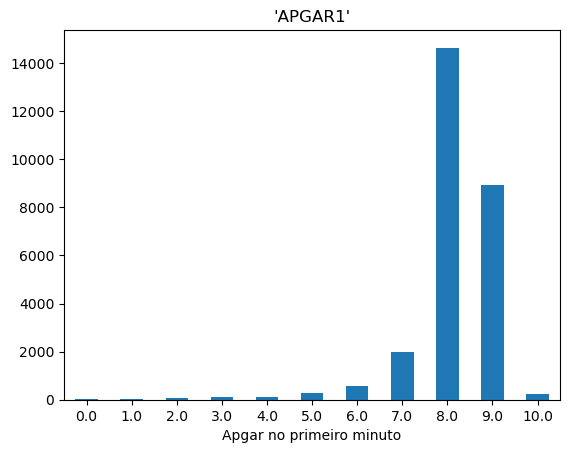

In [58]:
#gráfrico APGAR1
variaveis_grafico['apgar1'].value_counts().sort_index().plot.bar()
plt.title(label="'APGAR1'")
plt.xlabel(xlabel='Apgar no primeiro minuto')
plt.tick_params(axis='x', rotation=0)
plt.show()

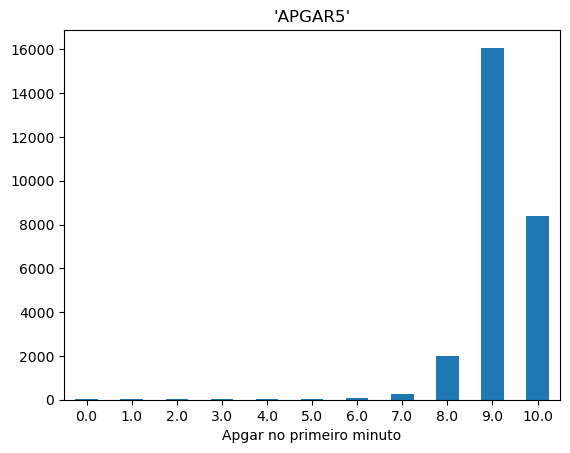

In [59]:
#gráfrico APGAR5
variaveis_grafico['apgar5'].value_counts().sort_index().plot.bar()
plt.title(label="'APGAR5'")
plt.xlabel(xlabel='Apgar no primeiro minuto')
plt.tick_params(axis='x', rotation=0)
plt.show()

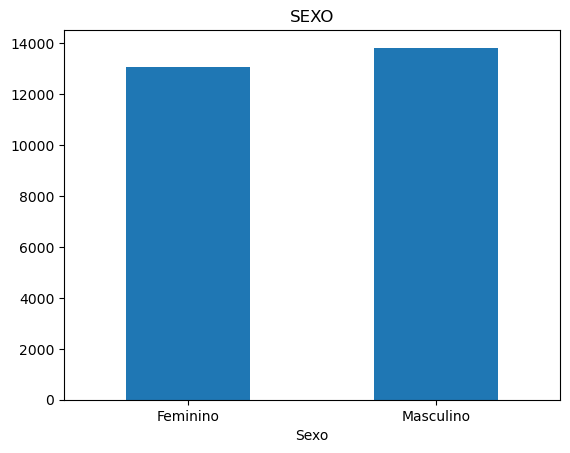

In [61]:
#gráfrico do sexo
variaveis_grafico['sexo'].value_counts().sort_index().plot.bar()
plt.title(label="SEXO")
plt.xlabel(xlabel='Sexo')
plt.tick_params(axis='x', rotation=0)
plt.show()

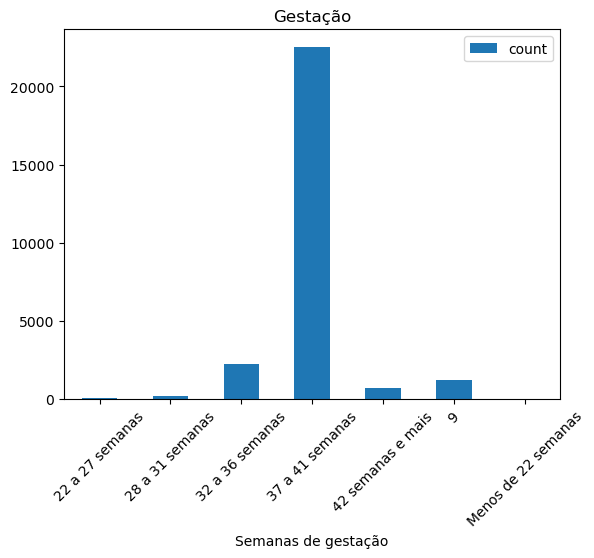

In [63]:
#gráfrico da gestação
variaveis_grafico['gestacao'].value_counts().sort_index().plot.bar()
plt.title(label="Gestação")
plt.xlabel(xlabel='Semanas de gestação')
plt.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

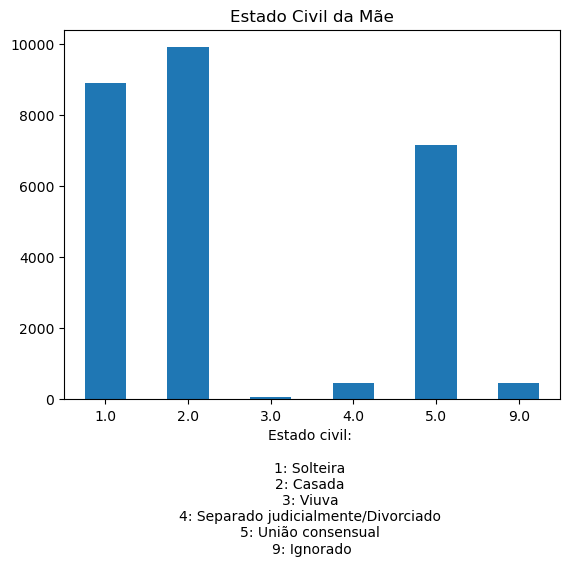

In [64]:
# gráfico de estado civil da mãe
variaveis_grafico['estado_civ_mae'].value_counts().sort_index().plot.bar()
plt.title(label="Estado Civil da Mãe")
plt.xlabel(xlabel='Estado civil: \n\n1: Solteira \n2: Casada \n3: Viuva \n4: Separado judicialmente/Divorciado \n5: União consensual \n9: Ignorado')
plt.tick_params(axis='x', rotation=0)
plt.show()

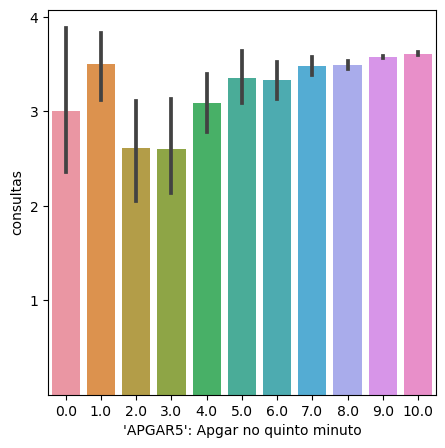

In [66]:
#gráfico de barras mostrando o APGAR5 médio por consultas
plt.rc('figure', figsize=(5, 5))
ax = sns.barplot(data=variaveis_grafico, 
                 x='apgar5', 
                 y='consultas')
ax.set_yticks(ticks=[1, 2, 3, 4])
plt.xlabel(xlabel="'APGAR5': Apgar no quinto minuto")

plt.show()

O baixo número de consultas de pré-natal tem relação com níveis mais baixos de APGAR5 de acordo com o gráfico

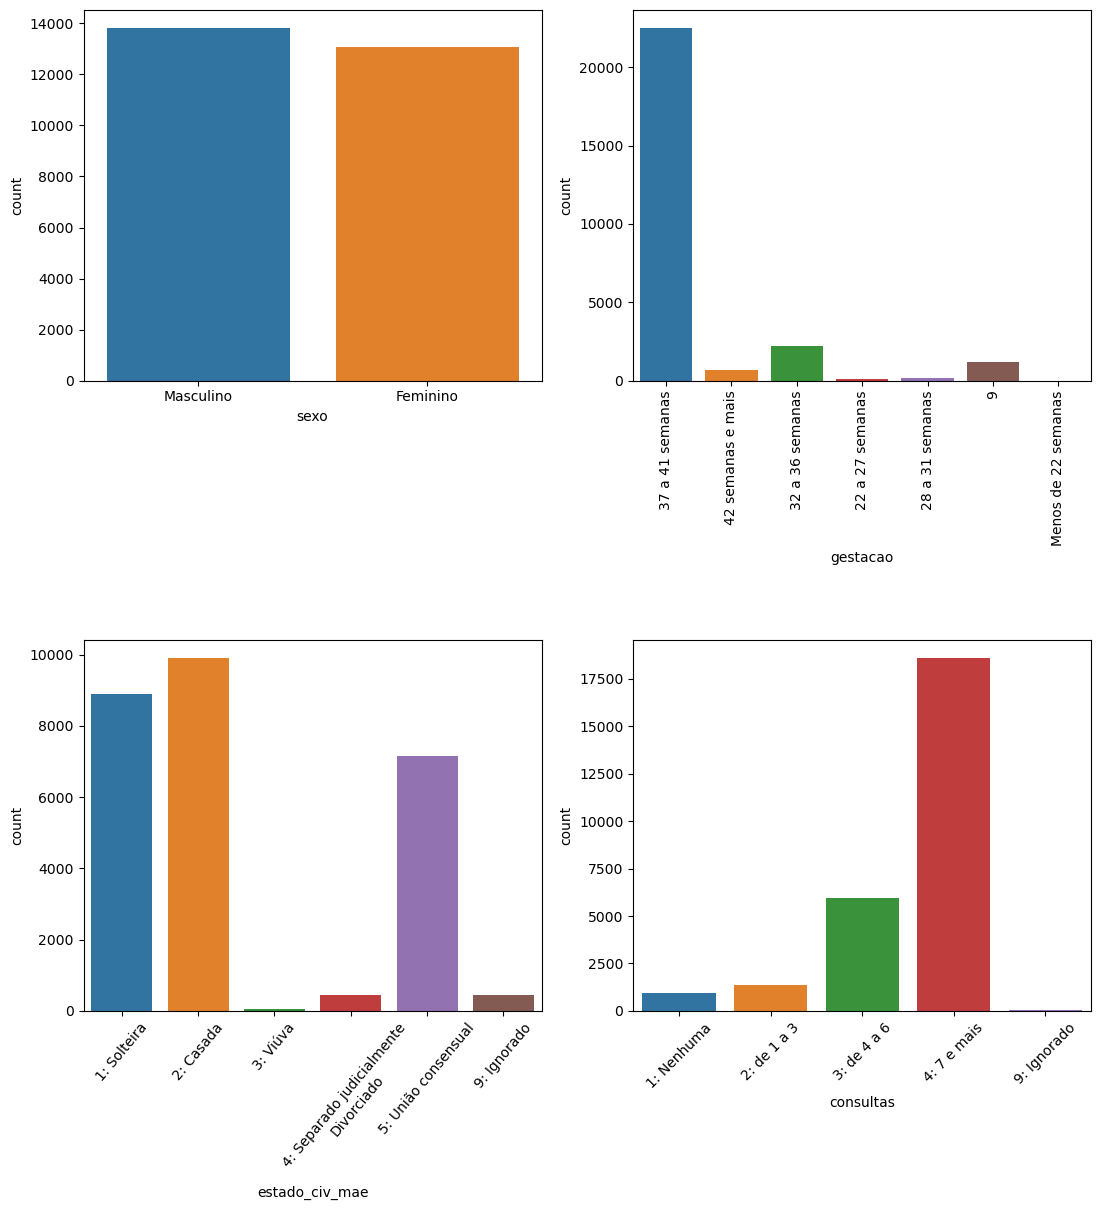

In [69]:
#painel com 4 gráficos mostrando as frequencias de sexo, gestação, estado civil da mãe e consultas de pré-natal
plt.close('all')
plt.rc('figure', figsize=(13, 13))
fig, axes = plt.subplots(2, 2)
axes[0,1].tick_params(axis="x", rotation=90)
fig.subplots_adjust(hspace=0.7)

ax1 = sns.countplot(ax = axes[0, 0], x='sexo', data=variaveis_grafico)
ax2 = sns.countplot(ax = axes[0, 1], x='gestacao', data=variaveis_grafico)
ax3 = sns.countplot(ax = axes[1, 0], x='estado_civ_mae', data=variaveis_grafico)
ax3.set_xticklabels(labels=['1: Solteira', 
                            '2: Casada', 
                            '3: Viúva', 
                            '4: Separado judicialmente\nDivorciado', 
                            '5: União consensual',
                            '9: Ignorado'], rotation = 50)
ax4 = sns.countplot(ax = axes[1, 1], x='consultas', data=variaveis_grafico)
ax4.set_xticklabels(labels=['1: Nenhuma', 
                            '2: de 1 a 3', 
                            '3: de 4 a 6', 
                            '4: 7 e mais', 
                            '9: Ignorado'],rotation = 45)

plt.show()

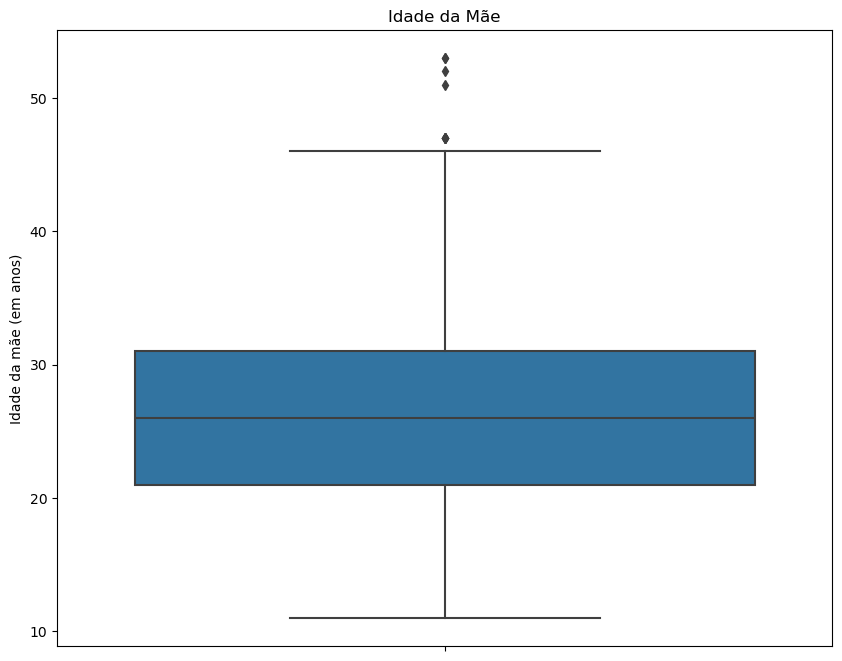

In [71]:
#gráfico boxplot com a idade da mãe
plt.rc('figure', figsize=(10,8))
fig, axes = plt.subplots(1,1)
sns.boxplot(y='idade_mae', data=variaveis_grafico, ax=axes)
axes.set_title(label='Idade da Mãe')
axes.set_ylabel(ylabel='Idade da mãe (em anos)')

plt.show()

O gráfico boxplot demonstra que as idades das mães se encontram geralmente entre 20 e 30 anos, com numero de mães considerável abaixo dos 20 anos.

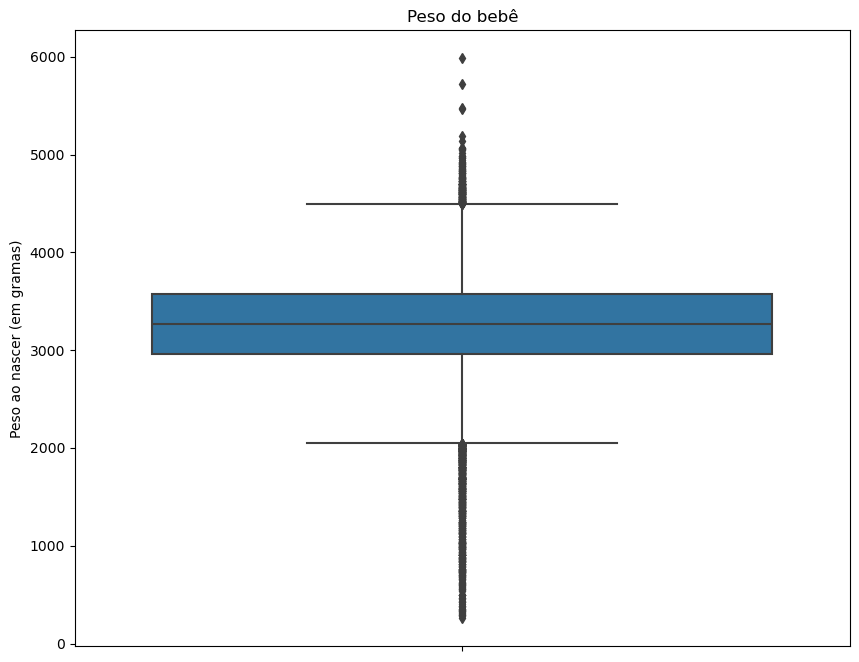

In [74]:
#gráfico boxplot com o peso do bebê
plt.rc('figure', figsize=(10,8))
fig, axes = plt.subplots(1,1)

sns.boxplot(y='peso', data=variaveis_grafico, ax=axes)
axes.set_title(label='Peso do bebê')
axes.set_ylabel(ylabel='Peso ao nascer (em gramas)')

plt.show()

O gráfico boxplot demonstra diversos valores discrepantes que podemos levar em consideração pricipalmente os pesos abaixo de 2500 g. O peso normal de um
rescém-nascido varia entre 2500g a 4500g.

C:\Users\User\anaconda3\Lib\site-packages\seaborn\distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


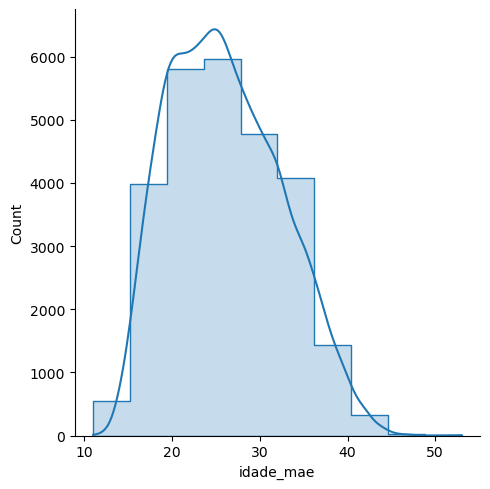

In [77]:
#histograma com a idade da mãe

sns.displot(data = variaveis_grafico['idade_mae'],alpha = .25,element = 'step',  kde = True, bins=10, ax=axes)

plt.show()

C:\Users\User\anaconda3\Lib\site-packages\seaborn\distributions.py:2142: UserWarning: `displot` is a figure-level function and does not accept the ax= parameter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


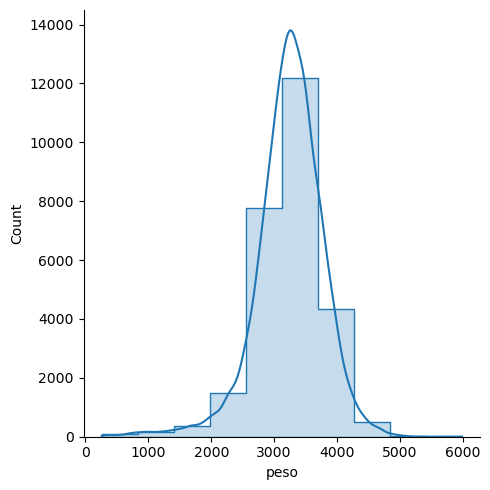

In [78]:
#histograma com o peso do bebê
sns.displot(data = variaveis_grafico['peso'],alpha = .25,element = 'step',  kde = True, bins=10, ax=axes)

plt.show()

In [79]:
#Checando a frequêcia de classificação de asfixia
rn_ro['class_asfix'].value_counts()

class_asfix
normal              26463
asfixia leve          320
asfixia severa         74
asfixia moderada       68
Name: count, dtype: int64

In [80]:
#Checando a frequência da cluna de gestação
rn_ro['gestacao'].value_counts()

gestacao
37 a 41 semanas        22523
32 a 36 semanas         2234
9                       1216
42 semanas e mais        698
28 a 31 semanas          162
22 a 27 semanas           85
Menos de 22 semanas        7
Name: count, dtype: int64

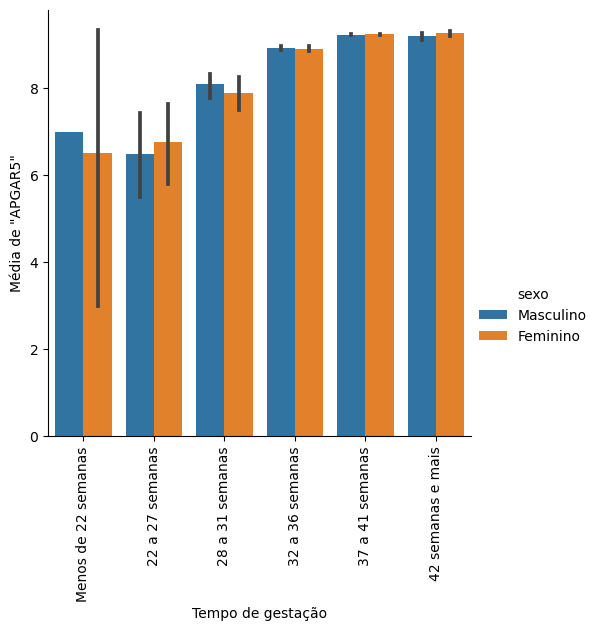

In [81]:
#Gráfico com a média de APGAR5 por semanas de gestação
sns.catplot(x='gestacao', 
            y='apgar5',
            hue='sexo', 
            data=rn_ro, 
            order=['Menos de 22 semanas', 
                   '22 a 27 semanas', 
                   '28 a 31 semanas', 
                   '32 a 36 semanas', 
                   '37 a 41 semanas', 
                   '42 semanas e mais'], 
            kind='bar')
plt.xticks(rotation=90)
plt.xlabel(xlabel='Tempo de gestação')
plt.ylabel(ylabel='Média de "APGAR5"')

plt.show()

É possível perceber aqui também, uma relação entre baixas semanas de gestção e valores baixos de APGAR5.

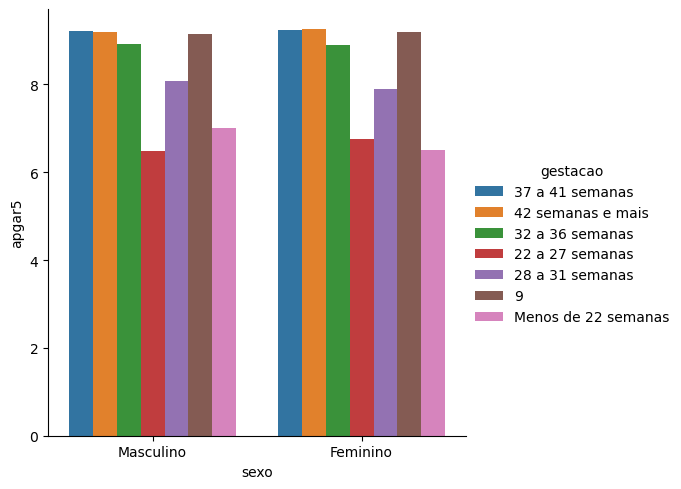

In [84]:
#Outra forma de visualizar os dados relacionando o APGAR5 às semanas de gestação
sns.catplot(x='sexo', y='apgar5',
            hue='gestacao',
            kind='bar',
            data=rn_ro,
            errorbar=None)
            

In [86]:
#tabela cruzada com APGAR5 nas colunas e gestação nas linhas
tabela_apgar5 = pd.crosstab(index=rn_ro['gestacao'], columns=rn_ro['class_asfix'])

tabela_apgar5 = tabela_apgar5.drop('9')

tabela_apgar5

class_asfix,asfixia leve,asfixia moderada,asfixia severa,normal
gestacao,,,,
22 a 27 semanas,12,1,21,51
28 a 31 semanas,18,12,3,129
32 a 36 semanas,73,19,8,2134
37 a 41 semanas,196,28,33,22266
42 semanas e mais,6,1,1,690
Menos de 22 semanas,1,0,2,4


In [96]:
#Somando os dados obtidos por variável de semanas de gestação
print(tabela_apgar5.sum(1))

gestacao
22 a 27 semanas           85
28 a 31 semanas          162
32 a 36 semanas         2234
37 a 41 semanas        22523
42 semanas e mais        698
Menos de 22 semanas        7
dtype: int64


In [98]:
#Percentuais de cada classe de gestação:
freq_tabela_apgar5  = tabela_apgar5.div(tabela_apgar5.sum(axis = 1), axis = 0)
print(freq_tabela_apgar5)

class_asfix          asfixia leve  asfixia moderada  asfixia severa    normal
gestacao                                                                     
22 a 27 semanas          0.141176          0.011765        0.247059  0.600000
28 a 31 semanas          0.111111          0.074074        0.018519  0.796296
32 a 36 semanas          0.032677          0.008505        0.003581  0.955237
37 a 41 semanas          0.008702          0.001243        0.001465  0.988589
42 semanas e mais        0.008596          0.001433        0.001433  0.988539
Menos de 22 semanas      0.142857          0.000000        0.285714  0.571429


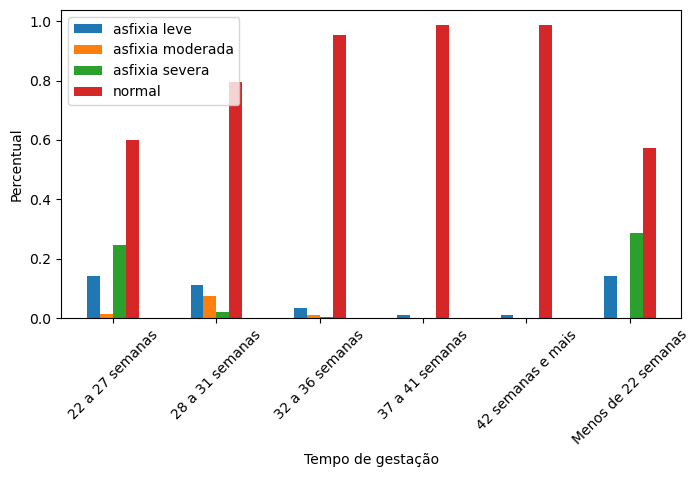

In [100]:
#Gráfico editado a partir dos dados percentuais acima
plt.rc('figure', figsize=(8,4))
freq_tabela_apgar5.plot.bar()
plt.xticks(rotation=45)
plt.xlabel(xlabel='Tempo de gestação')
plt.ylabel(ylabel='Percentual')
plt.legend(title='Apgar no quinto minuto',fontsize=5)
plt.legend(loc='upper left')

Os níveis de asfixia com relação às semanas de gestação apesar de percentuais baixos, temos que levar em consideração o tamanho da base e as variações.

Text(0.5, 1.0, 'Relação APGAR5 X Peso do bebê (barras)')

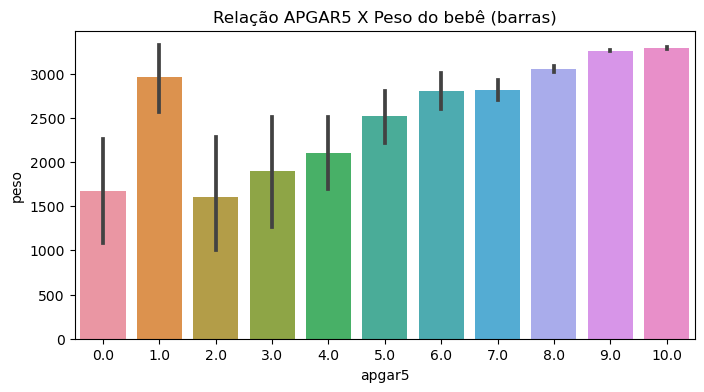

In [103]:
#Histograma de relação entre APGAR5 e peso do bebê
plt.rc('figure', figsize=(8,4))

ax1 = sns.barplot(x='apgar5', y='peso', data=rn_ro)
ax1.set_title(label='Relação APGAR5 X Peso do bebê (barras)')


Text(0.5, 1.0, 'Boxplot APGAR5 X Peso do bebê')

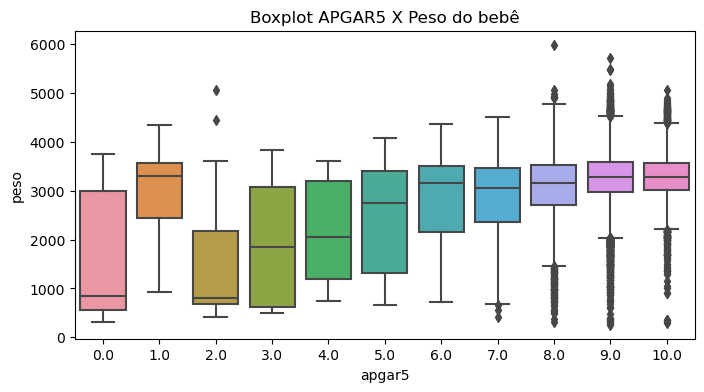

In [104]:
#Gráfico boxplot da relação entre APGAR5 e peso do bebê
ax2 = sns.boxplot(x='apgar5', y='peso', data=rn_ro)
ax2.set_title(label='Boxplot APGAR5 X Peso do bebê')

C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


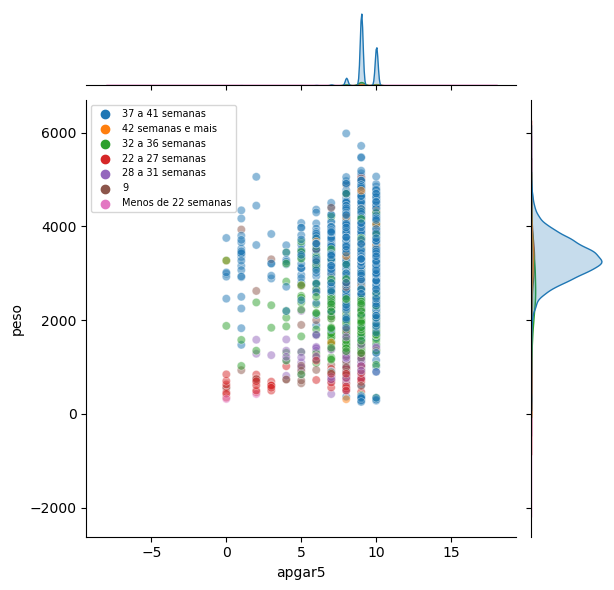

In [107]:
#Relação de APGAR5 , peso do bebê e semanas de gestação 
sns.jointplot(data=rn_ro, x='apgar5', y='peso',hue = 'gestacao',alpha = 0.5)
plt.legend(loc='best',fontsize=7)



## 
Ao observar as variáveis é possível perceber que existe relação entre o peso do bebê, APGAR5 e as semanas de gestação. Bebês com semanas de gestação menores apresentam pesos menores e valores de APGAR5 quase sempre inferiores a 10. Há também uma relação entre baixos pesos e semanas de gestação menores. Porém se o APGAR5 apresenta valores próximos a 10 também é possivel notar que o peso do bebê não tem tanta variação em relação aos valores mais baixos de APGAR5.

## 6. Modelo de Machine Learning

Nessa etapa iremos criar uma base de metadados para servir de estrutura para uma árvore de decisão. Esta árvore irá tentar prever se o rescém-nascido irá ter algum risco de asfixia com base nas semanas de gestação, quantidade de filhos vivos e peso do bebê.

In [112]:
#Carregando o DataFrame e tratando os dados faltantes e duplicados.
df = pd.read_csv('SINASC_RO_2019_nova_versao.csv')
df

,Unnamed: 0,origem,code_estab,code_mun_nasc,loc_nasc,idade_mae,estado_civ_mae,esc_mae,cod_ocup_mae,qtd_fil_vivo,...,contador,mun_res_status,mun_res_tipo,mun_res_nome,mun_res_uf,mun_res_lat,mun_res_lon,mun_res_alt,mun_res_area,class_asfix
0,0,1,2679477.0,110001,1,19,5.0,8 a 11 anos,NaN,0.0,...,1,ATIVO,MUNIC,Alta Floresta D'Oeste,Rondônia,-11.93554,-61.99982,338.0,7067.025,normal
1,1,1,2679477.0,110001,1,29,2.0,8 a 11 anos,999992.0,1.0,...,2,ATIVO,MUNIC,Alta Floresta D'Oeste,Rondônia,-11.93554,-61.99982,338.0,7067.025,normal
2,2,1,2679477.0,110001,1,37,9.0,8 a 11 anos,513205.0,2.0,...,3,ATIVO,MUNIC,Alta Floresta D'Oeste,Rondônia,-11.93554,-61.99982,338.0,7067.025,normal
3,3,1,2516500.0,110001,1,30,5.0,12 anos ou mais,231205.0,0.0,...,4,ATIVO,MUNIC,Alto Alegre dos Parecis,Rondônia,-12.13178,-61.85308,397.0,3958.273,normal
4,4,1,2516500.0,110001,1,30,2.0,8 a 11 anos,999992.0,1.0,...,5,ATIVO,MUNIC,Alta Floresta D'Oeste,Rondônia,-11.93554,-61.99982,338.0,7067.025,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26920,27023,1,2604388.0,510340,1,32,2.0,12 anos ou mais,333115.0,1.0,...,2767632,ATIVO,MUNIC,Vilhena,Rondônia,-12.74137,-60.13858,595.0,11518.915,normal
26921,27024,1,2752654.0,510675,1,19,1.0,8 a 11 anos,999992.0,0.0,...,2772678,ATIVO,MUNIC,Chupinguaia,Rondônia,-12.55684,-60.90185,340.0,5126.723,normal
26922,27025,1,9659366.0,510787,1,24,2.0,8 a 11 anos,421125.0,0.0,...,2776905,ATIVO,MUNIC,Vilhena,Rondônia,-12.74137,-60.13858,595.0,11518.915,normal
26923,27026,1,9659366.0,510787,1,21,2.0,8 a 11 anos,999992.0,1.0,...,2777105,ATIVO,MUNIC,Vilhena,Rondônia,-12.74137,-60.13858,595.0,11518.915,normal


In [114]:
#Checando as lnhas duplicadas
print('Quantidade total de linhas: {}'.format(len(df)))
print('Número de linhas duplicadas: {}'.format(df.duplicated().sum()))

Quantidade total de linhas: 26925
Número de linhas duplicadas: 0


In [116]:
#Somando os dados faltantes
df.isna().sum()

Unnamed: 0        0
origem            0
code_estab       66
code_mun_nasc     0
loc_nasc          0
                 ..
mun_res_lat       1
mun_res_lon       1
mun_res_alt       1
mun_res_area      1
class_asfix       0
Length: 71, dtype: int64

In [118]:
#calculando o percentual de dados faltantes
percentage = (df.isnull().sum() / len(df)) * 100
percentage

Unnamed: 0       0.000000
origem           0.000000
code_estab       0.245125
code_mun_nasc    0.000000
loc_nasc         0.000000
                   ...   
mun_res_lat      0.003714
mun_res_lon      0.003714
mun_res_alt      0.003714
mun_res_area     0.003714
class_asfix      0.000000
Length: 71, dtype: float64

In [120]:
#Retirando todos os dados faltantes para a criação do modelo de machine learning
df_sem_na = df.dropna(axis=1)
df_sem_na.isna().sum()
df_sem_na.reset_index(drop=True, inplace=True)

In [122]:
#Verificando a quantidade de linhas e colunas após as remoções
df_sem_na.shape

(26925, 32)

In [124]:
#verificando o final do dataframe para avaliar a adequação da indexação após a remoção de dados ausentes.
df_sem_na.tail()

,Unnamed: 0,origem,code_mun_nasc,loc_nasc,idade_mae,estado_civ_mae,esc_mae,qtd_fil_vivo,cod_mun_res,gestacao,...,cod_pais_res,tp_robson,par_idade,kotel_chuck,contador,mun_res_status,mun_res_tipo,mun_res_nome,mun_res_uf,class_asfix
26920,27023,1,510340,1,32,2.0,12 anos ou mais,1.0,110030,32 a 36 semanas,...,1,7,1,5,2767632,ATIVO,MUNIC,Vilhena,Rondônia,normal
26921,27024,1,510675,1,19,1.0,8 a 11 anos,0.0,110092,37 a 41 semanas,...,1,1,0,5,2772678,ATIVO,MUNIC,Chupinguaia,Rondônia,normal
26922,27025,1,510787,1,24,2.0,8 a 11 anos,0.0,110030,37 a 41 semanas,...,1,3,1,5,2776905,ATIVO,MUNIC,Vilhena,Rondônia,normal
26923,27026,1,510787,1,21,2.0,8 a 11 anos,1.0,110030,32 a 36 semanas,...,1,10,1,5,2777105,ATIVO,MUNIC,Vilhena,Rondônia,normal
26924,27027,1,510792,1,18,5.0,8 a 11 anos,1.0,110050,37 a 41 semanas,...,1,7,1,5,2780269,ATIVO,MUNIC,Novo Horizonte do Oeste,Rondônia,normal


In [126]:
#Atribuido uma coluna para verificar Apgar5 e classificar nossa variável default
# 0 = Valores normais de APGAR. 
# 1 = Qualquer parâmetro fora do normal , sendo considerado como quadro de asfixia.

df_sem_na.loc[df_sem_na['class_asfix'] == 'normal', 'apgar5_risco'] = 0
df_sem_na.loc[df_sem_na['class_asfix'] != 'normal', 'apgar5_risco'] = 1

C:\Users\User\AppData\Local\Temp\ipykernel_424\3159471128.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sem_na.loc[df_sem_na['class_asfix'] == 'normal', 'apgar5_risco'] = 0


In [128]:
#Verificando a frequencia dos valores de APGAR
df_sem_na['apgar5_risco'].value_counts()

apgar5_risco
0.0    26463
1.0      462
Name: count, dtype: int64

In [130]:
#Checando a frequência da coluna de quantidade de filhos
df_sem_na['qtd_fil_vivo'].value_counts()

qtd_fil_vivo
0.0     10871
1.0      9361
2.0      4454
3.0      1362
4.0       475
5.0       212
6.0       106
7.0        41
8.0        23
9.0         8
10.0        6
12.0        3
11.0        1
30.0        1
14.0        1
Name: count, dtype: int64

In [132]:
#Os dados de pessoas com mais de 8 filhos irão ampliar os branches da nossa árvore de forma desnecessária.
#Como são poucas linhas iremos removê-las.
df_limpo = df_sem_na[df_sem_na['qtd_fil_vivo'] <= 8]

In [134]:
df_limpo['qtd_fil_vivo'].value_counts()

qtd_fil_vivo
0.0    10871
1.0     9361
2.0     4454
3.0     1362
4.0      475
5.0      212
6.0      106
7.0       41
8.0       23
Name: count, dtype: int64

In [135]:
#Verificando as frequências de valores de gestação
df_limpo['gestacao'].value_counts()

gestacao
37 a 41 semanas        22509
32 a 36 semanas         2231
9                       1214
42 semanas e mais        697
28 a 31 semanas          162
22 a 27 semanas           85
Menos de 22 semanas        7
Name: count, dtype: int64

In [138]:
#Removendo os dados '9:não informados' da coluna de gestação
df_limpo = df_limpo[df_limpo['gestacao'] != '9']

In [140]:
#Verificando as frequências de valores de gravidez
df_limpo['gravidez'].value_counts()

gravidez
Única              25165
Dupla                461
9                     60
Tríplice e mais        5
Name: count, dtype: int64

In [141]:
#Removendo os dados '9:não informados' da coluna de gravidez
df_limpo = df_limpo[df_limpo['gravidez'] != '9']

In [144]:
#Verificando as frequências de valores de consultas
df_limpo['consultas'].value_counts()

consultas
4    17942
3     5695
2     1267
1      686
9       41
Name: count, dtype: int64

In [145]:
#Removendo os dados '9:não informados' da coluna de consultas
df_limpo = df_limpo[df_limpo['consultas'] != 9]

In [148]:
#Separando as colunas, agora sem dados ausentes, em um novo dataframe para a árvore de decisão
df_arvore = df_limpo[['qtd_fil_vivo','peso','gestacao','gravidez','consultas','apgar5_risco']]
df_arvore.reset_index(drop=True, inplace=True)
df_arvore

,qtd_fil_vivo,peso,gestacao,gravidez,consultas,apgar5_risco
0,0.0,3685,37 a 41 semanas,Única,4,0.0
1,1.0,3055,37 a 41 semanas,Única,4,0.0
2,2.0,3460,37 a 41 semanas,Única,4,0.0
3,0.0,2982,37 a 41 semanas,Única,3,0.0
4,1.0,3310,37 a 41 semanas,Única,4,0.0
...,...,...,...,...,...,...
25585,1.0,2110,32 a 36 semanas,Única,4,0.0
25586,0.0,3310,37 a 41 semanas,Única,4,0.0
25587,0.0,3065,37 a 41 semanas,Única,4,0.0
25588,1.0,2352,32 a 36 semanas,Única,4,0.0


In [150]:
#Checando as variáveis alvo após as tratativas de dados
df_arvore['apgar5_risco'].value_counts()

apgar5_risco
0.0    25159
1.0      431
Name: count, dtype: int64

In [152]:
#transformando o dataframe em variáveis dummy
df_arvore = pd.get_dummies(df_arvore, columns=['qtd_fil_vivo','gravidez','gestacao','consultas',], drop_first=True)

In [154]:
#verificando as estrutras de dummies
df_arvore

,peso,apgar5_risco,qtd_fil_vivo_1.0,qtd_fil_vivo_2.0,qtd_fil_vivo_3.0,qtd_fil_vivo_4.0,qtd_fil_vivo_5.0,qtd_fil_vivo_6.0,qtd_fil_vivo_7.0,qtd_fil_vivo_8.0,gravidez_Tríplice e mais,gravidez_Única,gestacao_28 a 31 semanas,gestacao_32 a 36 semanas,gestacao_37 a 41 semanas,gestacao_42 semanas e mais,gestacao_Menos de 22 semanas,consultas_2,consultas_3,consultas_4
0,3685,0.0,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True
1,3055,0.0,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True
2,3460,0.0,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True
3,2982,0.0,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False
4,3310,0.0,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25585,2110,0.0,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True
25586,3310,0.0,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True
25587,3065,0.0,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,True
25588,2352,0.0,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True


In [156]:
#Consulta das variáveis para criação da árvore de decisão
df_arvore.dtypes

peso                              int64
apgar5_risco                    float64
qtd_fil_vivo_1.0                   bool
qtd_fil_vivo_2.0                   bool
qtd_fil_vivo_3.0                   bool
qtd_fil_vivo_4.0                   bool
qtd_fil_vivo_5.0                   bool
qtd_fil_vivo_6.0                   bool
qtd_fil_vivo_7.0                   bool
qtd_fil_vivo_8.0                   bool
gravidez_Tríplice e mais           bool
gravidez_Única                     bool
gestacao_28 a 31 semanas           bool
gestacao_32 a 36 semanas           bool
gestacao_37 a 41 semanas           bool
gestacao_42 semanas e mais         bool
gestacao_Menos de 22 semanas       bool
consultas_2                        bool
consultas_3                        bool
consultas_4                        bool
dtype: object

In [158]:
#Como os dados devem ser do tipo float ou int, é preciso transformar alguns dados
df_arvore.apgar5_risco.astype(int)

0        0
1        0
2        0
3        0
4        0
        ..
25585    0
25586    0
25587    0
25588    0
25589    0
Name: apgar5_risco, Length: 25590, dtype: int32

In [160]:
#Transformando a coluna apgar5_risco em tipo int
df_arvore.apgar5_risco = df_arvore.apgar5_risco.astype(int)

In [162]:
df_arvore.dtypes

peso                            int64
apgar5_risco                    int32
qtd_fil_vivo_1.0                 bool
qtd_fil_vivo_2.0                 bool
qtd_fil_vivo_3.0                 bool
qtd_fil_vivo_4.0                 bool
qtd_fil_vivo_5.0                 bool
qtd_fil_vivo_6.0                 bool
qtd_fil_vivo_7.0                 bool
qtd_fil_vivo_8.0                 bool
gravidez_Tríplice e mais         bool
gravidez_Única                   bool
gestacao_28 a 31 semanas         bool
gestacao_32 a 36 semanas         bool
gestacao_37 a 41 semanas         bool
gestacao_42 semanas e mais       bool
gestacao_Menos de 22 semanas     bool
consultas_2                      bool
consultas_3                      bool
consultas_4                      bool
dtype: object

In [164]:
#Separando as variáveis target
y = df_arvore.apgar5_risco
y

0        0
1        0
2        0
3        0
4        0
        ..
25585    0
25586    0
25587    0
25588    0
25589    0
Name: apgar5_risco, Length: 25590, dtype: int32

In [166]:
#Separando as variáveis explicativas
X = df_arvore.drop('apgar5_risco',axis=1)

In [168]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25590 entries, 0 to 25589
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   peso                          25590 non-null  int64
 1   qtd_fil_vivo_1.0              25590 non-null  bool 
 2   qtd_fil_vivo_2.0              25590 non-null  bool 
 3   qtd_fil_vivo_3.0              25590 non-null  bool 
 4   qtd_fil_vivo_4.0              25590 non-null  bool 
 5   qtd_fil_vivo_5.0              25590 non-null  bool 
 6   qtd_fil_vivo_6.0              25590 non-null  bool 
 7   qtd_fil_vivo_7.0              25590 non-null  bool 
 8   qtd_fil_vivo_8.0              25590 non-null  bool 
 9   gravidez_Tríplice e mais      25590 non-null  bool 
 10  gravidez_Única                25590 non-null  bool 
 11  gestacao_28 a 31 semanas      25590 non-null  bool 
 12  gestacao_32 a 36 semanas      25590 non-null  bool 
 13  gestacao_37 a 41 semanas      2

In [170]:
# Separando a base em 70% para treinamento e 30% para validação:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=100)

In [172]:
#estruturas das bases de treino e teste 
print('Quantidade de linhas e colunas de X_train (70%):', 
      X_train.shape)
print('Quantidade de linhas e colunas de X_test (30%):', 
      X_test.shape, '\n')

print('Quantidade de linhas de y_train (70%):', 
      len(y_train))
print('Quantidade de linhas de y_test (30%):', 
      len(y_test))

Quantidade de linhas e colunas de X_train (70%): (17913, 19)
Quantidade de linhas e colunas de X_test (30%): (7677, 19) 

Quantidade de linhas de y_train (70%): 17913
Quantidade de linhas de y_test (30%): 7677


In [174]:
# Definindo um objeto com a função da árvore de decisão.
clf = DecisionTreeClassifier(random_state=100)
clf

DecisionTreeClassifier(random_state=100)

In [176]:
#Treinando o modelo com os dados já separados.
clf = clf.fit(X=X_train, 
              y=y_train)
clf

DecisionTreeClassifier(random_state=100)

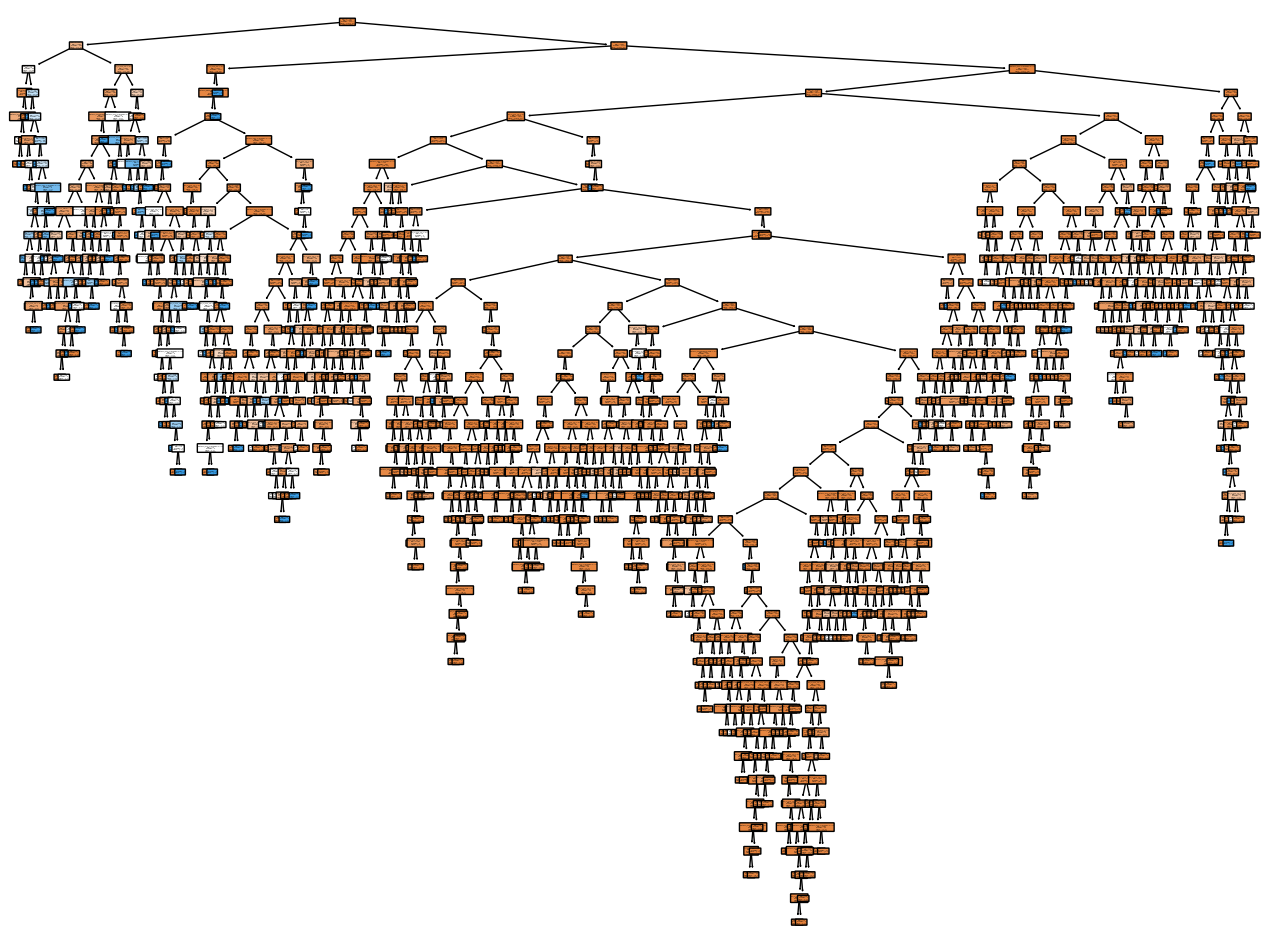

In [142]:
#Visualizando a árvore de decisão
plt.figure(figsize=(16,12))
plot_tree(decision_tree=clf,
          feature_names=X_train.columns,
          class_names=['normal', 'risco'],
          filled=True, 
          rounded=True)

plt.show()

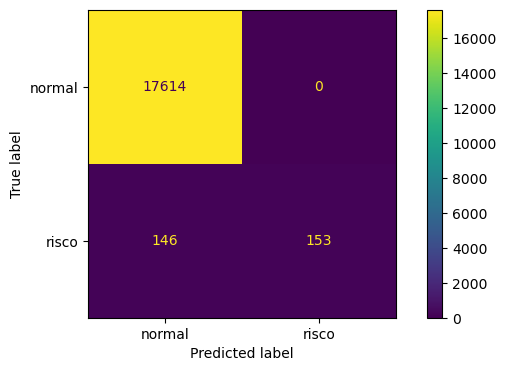

In [178]:
#Criando e visualizando a matriz de decisão da base de treino
y_pred = clf.predict(X_train)

cm = confusion_matrix(y_train, y_pred)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'risco'])

disp_train.plot()


In [180]:
# Calculando a acurácia na base de treinamento.

print('Acurácia:')
predict_train = clf.predict(X=X_train)
accuracy_score(y_true=y_train, 
               y_pred=predict_train)

Acurácia:


0.9918494947803271

In [182]:
#Avaliando os valores preditos obtidos com a base de treino
predict_test = clf.predict(X=X_test)

print('Valores preditos:') 
print(pd.Series(predict_test).value_counts(), '\n')

print('Valores reais:')
print(y_test.value_counts())

Valores preditos:
0    7594
1      83
Name: count, dtype: int64 

Valores reais:
apgar5_risco
0    7545
1     132
Name: count, dtype: int64


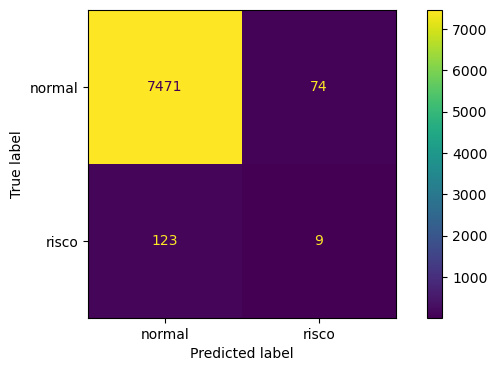

In [184]:
#  matriz de confusão para a base de teste.

ConfusionMatrixDisplay.from_estimator(estimator=clf, 
                                      X=X_test, 
                                      y=y_test, 
                                      display_labels=['normal', 'risco'])

plt.show()

In [186]:
# acurácia da base de teste. Comparando com a acurácia da base de treinamento.

print('Acurácia da base de teste:', 
      accuracy_score(y_true=y_test, 
                     y_pred=predict_test), '\n')

print('Acurácia da base de treinamento:', 
      accuracy_score(y_true=y_train, 
                     y_pred=predict_train))

Acurácia da base de teste: 0.9743389344796144 

Acurácia da base de treinamento: 0.9918494947803271


In [188]:
# treinando uma nova árvore com número mínimo de observações por folha de 5 e máximo de profundidade de 10. 
nova_clf = DecisionTreeClassifier(max_depth=10, 
                                  min_samples_leaf=5, 
                                  random_state=123)
nova_clf = nova_clf.fit(X=X_train, 
                        y=y_train)

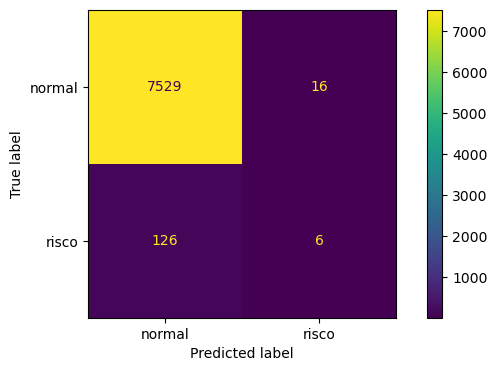

In [190]:
#Visualização da matriz de decisão da nova árvore:
ConfusionMatrixDisplay.from_estimator(estimator=nova_clf, 
                                      X=X_test, 
                                      y=y_test, 
                                      display_labels=['normal', 'risco'])

plt.show()

In [192]:
#Calculando a acurácia 
(7529+6) / (7529+16+126+6)


0.9815031913507881

O modelo gerado apresentou altos níveis de acurácia tanto para a base de treino como para a base de testes. Portando é possível aplicar esse modelo em dados futuros.